In [2]:
import pandas as pd
import optuna
import numpy as np
import warnings
import logging
import copy
import joblib
import timeout_decorator
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


from lightgbm import LGBMClassifier
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

logger = logging.getLogger()

optuna.logging.set_verbosity(optuna.logging.WARNING)

ConvergenceWarning("ignore")

sklearn.exceptions.ConvergenceWarning('ignore')

In [3]:
# Set random seed so this part is reproducible
# https://www.random.org/ 2023-08-09
np.random.seed(3866)

In [4]:
class StopWhenPerfectScoreReached:
    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value == 1.0:
            study.stop()

def get_elasticnet_model(X_train: np.ndarray, y_train: np.ndarray, n_trials=100):

    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned)
    def objective(trial):
    
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])
        
        penalty = trial.suggest_categorical("penalty", ["elasticnet"])
        
        solver = trial.suggest_categorical("solver", ["saga"])

        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
        
        logreg_c = trial.suggest_float("logreg_c", 1e-4, 1e2, log=True)
        
        weight = trial.suggest_categorical("weight", [None, "balanced"])

        max_iter = trial.suggest_int("max_iter", 1000, 10000, log=True)

        clf = linear_model.LogisticRegression(
                        C=logreg_c,
                        penalty=penalty,
                        solver=solver,
                        random_state=3866, 
                        max_iter=max_iter,
                        l1_ratio=l1_ratio,
                        class_weight=weight,
                        n_jobs=-1)

        try:

            with warnings.catch_warnings():
                
                warnings.filterwarnings("ignore")

                scores = cross_val_score(clf, 
                                        X_train, 
                                        y_train, 
                                        cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                        n_jobs=-1,
                                        scoring="f1")

                return np.median(scores).item()
            
        except Exception as e:
            raise optuna.TrialPruned(e)

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = linear_model.LogisticRegression(
        C=study.best_params["logreg_c"],
        penalty=study.best_params["penalty"],
        solver=study.best_params["solver"],
        random_state=3866, 
        max_iter=study.best_params["max_iter"], 
        l1_ratio=study.best_params["l1_ratio"],
        class_weight=study.best_params["weight"],
        n_jobs=-1)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        clf.fit(X_train, y_train)

    return clf, study.best_value


def get_svm_rbf_model(X_train, y_train, n_trials=500):
    
    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned)
    def objective(trial) -> float:
    
        kernel = trial.suggest_categorical("kernel",
                                           ["rbf"])
        
        weight = trial.suggest_categorical("weight",
                                           [None, "balanced"])
        
        gamma = trial.suggest_float("gamma", 1e-4, 1e4, log=True)
        
        logreg_c = trial.suggest_float("logreg_c", 1e-4, 1e4, log=True)
        
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])

        clf = SVC(kernel=kernel, 
                  class_weight=weight, 
                  C=logreg_c,
                  gamma=gamma,
                  random_state=3866, 
                  max_iter=-1,
                  probability=True)

        try:
            scores = cross_val_score(clf, 
                                     X_train, 
                                     y_train, 
                                     cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                     n_jobs=-1,
                                     scoring="f1")
                                     
            return np.median(scores).item()
            
        except Exception as e:
            logger.exception(e)
        
        return np.nan

    study = optuna.create_study(direction="maximize", 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = SVC(kernel=study.best_params["kernel"], 
              class_weight=study.best_params["weight"], 
              C=study.best_params["logreg_c"], 
              gamma=study.best_params["gamma"], 
              random_state=3866, 
              max_iter=-1,
              probability=True)

    clf.fit(X_train, y_train)

    return clf, study.best_value


def get_svm_linear_model(X_train, y_train, n_trials=500):

    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned) 
    def objective(trial) -> float:
    
        kernel = trial.suggest_categorical("kernel",
                                           ["linear"])
        
        weight = trial.suggest_categorical("weight",
                                           [None, "balanced"])
        
        gamma = trial.suggest_float("gamma", 1e-4, 1e4, log=True)
        
        logreg_c = trial.suggest_float("logreg_c", 1e-4, 1e4, log=True)
        
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])

        clf = SVC(kernel=kernel, 
                  class_weight=weight, 
                  C=logreg_c,
                  gamma=gamma,
                  random_state=3866, 
                  max_iter=-1)

        try:
            scores = cross_val_score(clf, 
                                     X_train, 
                                     y_train, 
                                     cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                     n_jobs=-1,
                                     scoring="f1")

            return np.median(scores).item()
            
        except Exception as e:
            logger.exception(e)
        
        return np.nan

    study = optuna.create_study(direction="maximize", 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = SVC(kernel=study.best_params["kernel"], 
              class_weight=study.best_params["weight"], 
              C=study.best_params["logreg_c"], 
              gamma=study.best_params["gamma"], 
              random_state=3866, 
              max_iter=-1)

    clf.fit(X_train, y_train)

    return clf, study.best_value


def get_lightgbm_model(X_train, y_train, n_trials=500):
    """
    Optimizes and returns a LightGBM classifier object

    Args:
        data (np.array): _description_
        labels (np.array): _description_
        n_trials (int, optional): Number of optimization trials. Defaults to 100.

    Returns:
        LGBMClassifier: Optimized instance of lightgbm classifier
    """

    @timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned)
    def objective(trial) -> float:
    
        splits = trial.suggest_categorical("splits", [2, 3, 4, 5])

        # Can't have more splits than positive cases
        if splits >= len(y_train[y_train == 1]):
            raise optuna.exceptions.TrialPruned()

        param = {
            "objective": "binary",
            "metric": 'binary_logloss',
            "verbosity": -1,
            "boosting_type": "gbdt",
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "is_unbalance": True,    # Assumes unbalanced because that's usually the case
            }

        clf = LGBMClassifier()
        clf.set_params(**param)
        
        try:

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                scores = cross_val_score(clf, 
                                        X_train, 
                                        y_train.ravel(), 
                                        cv=RepeatedStratifiedKFold(n_splits=splits, n_repeats=5, random_state=3866),
                                        n_jobs=-1,
                                        scoring="f1")

            return np.median(scores).item()
           
        except Exception as e:
            logger.exception(e)
            
        return np.nan

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(objective, n_trials=n_trials, catch=(), callbacks=[StopWhenPerfectScoreReached()])

    clf = LGBMClassifier()
    param = copy.deepcopy(study.best_params)
    del param["splits"]
    clf.set_params(**param)
    clf.fit(X_train, y_train)

    return clf, study.best_value

In [5]:
#
# Train
#
trainX = pd.read_csv("../../../../data/enrichment/IO-Atlas-NSCLC-TPM-MinMaxNorm-TRAIN-2023-08-10-V4-response-subtype-clusters.tsv",
                         sep='\t')

trainX.index = [x.replace('.', '-') for x in trainX.index.values]

trainY = pd.read_csv("../../../../data/expression/processed/train/V4/IO-Atlas-NSCLC-LABEL-TRAIN-2023-08-10-V4.tsv",
                    sep='\t',
                    index_col=0,
                    header=None)

trainX = trainX.reindex(trainY.index)

#
# Test
#
testX = pd.read_csv("../../../../data/enrichment/IO-Atlas-NSCLC-TPM-MinMaxNorm-TEST-2023-08-10-V4-response-subtype-clusters.tsv",
                         sep='\t')

testX.index = [x.replace('.', '-') for x in testX.index.values]

testY = pd.read_csv("../../../../data/expression/processed/test/V4/IO-Atlas-NSCLC-LABEL-TEST-2023-08-10-V4.tsv",
                    sep='\t',
                    index_col=0,
                    header=None)

testX = testX.reindex(testY.index)

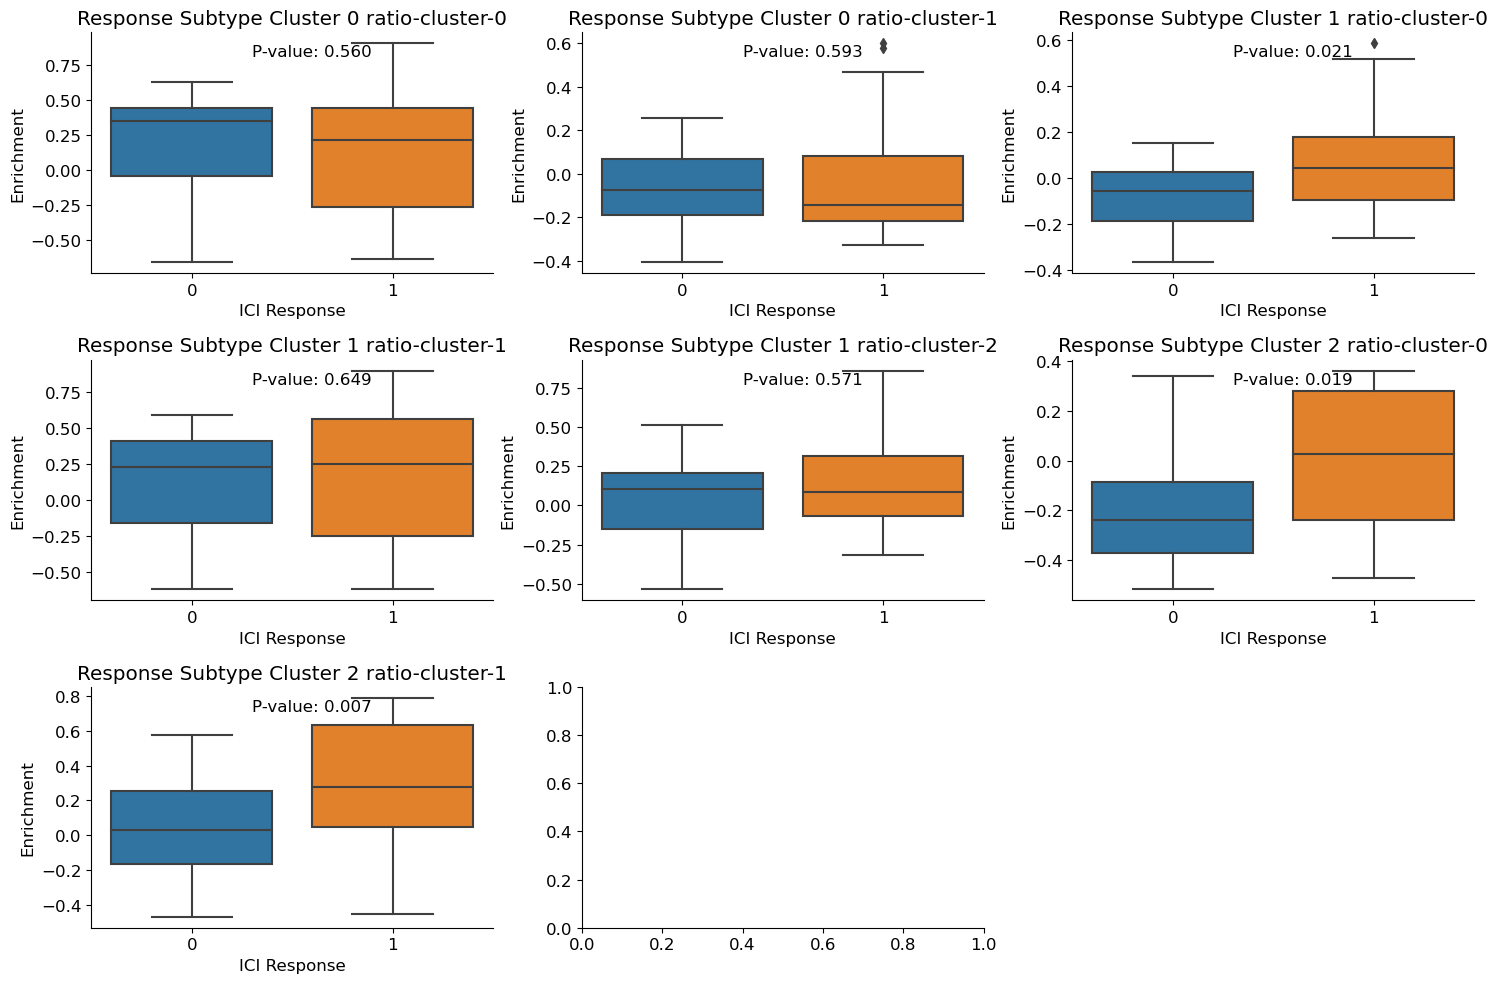

In [6]:
from scipy.stats import mannwhitneyu

fig, axes = plt.subplots(3, 3, figsize=(15, 10))

i = 0
for cluster in trainX.columns:
    
    data = pd.DataFrame()
    data["label"] = trainY[1].values
    data[cluster] = trainX[cluster].values
    stat, pval = mannwhitneyu(data[data["label"] == 1].iloc[:, 1].values, data[data["label"] == 0].iloc[:, 1].values)
    
    sns.boxplot(x="label", y=cluster, data=data, ax=axes.flat[i])
    axes.flat[i].annotate(f"P-value: {pval:.3f}", xy=(0.4, 0.9), xycoords='axes fraction')
    
    axes.flat[i].set_title(cluster)
    axes.flat[i].set_xlabel("ICI Response")
    axes.flat[i].set_ylabel("Enrichment")
    
    i += 1
    
axes.flat[-1].set_visible(False) 
sns.despine()  
plt.tight_layout()
plt.show()

In [7]:
elastic_net_model, elastic_net_model_best_value = get_elasticnet_model(trainX.values, trainY.values.ravel(), n_trials=100)

with open("../../../../data/pickles/su2c-elastic-net-model.joblib", "wb") as f:
    joblib.dump(elastic_net_model, f)

In [8]:
elastic_net_test_yhat = elastic_net_model.predict(testX.values)
f1_score(testY, elastic_net_test_yhat)

0.8333333333333333

In [9]:
rbf_svm_model, rbf_svm_model_best_value = get_svm_rbf_model(trainX.values, trainY.values.ravel(), n_trials=100)

In [10]:
with open("../../../../data/pickles/su2c-rbf-svm-model.joblib", "wb") as f:
    joblib.dump(rbf_svm_model, f)

In [11]:
rbf_svm_test_yhat = rbf_svm_model.predict(testX.values)
f1_score(testY, rbf_svm_test_yhat)

0.7692307692307692

In [12]:
linear_svm_model, linear_svm_model_best_value = get_svm_linear_model(trainX.values, trainY.values.ravel(), n_trials=100)

In [13]:
with open("../../../../data/pickles/su2c-linear-svm-model.joblib", "wb") as f:
    joblib.dump(linear_svm_model, f)

In [14]:
linear_svm_test_yhat = linear_svm_model.predict(testX.values)
f1_score(testY, linear_svm_test_yhat)

0.8333333333333333

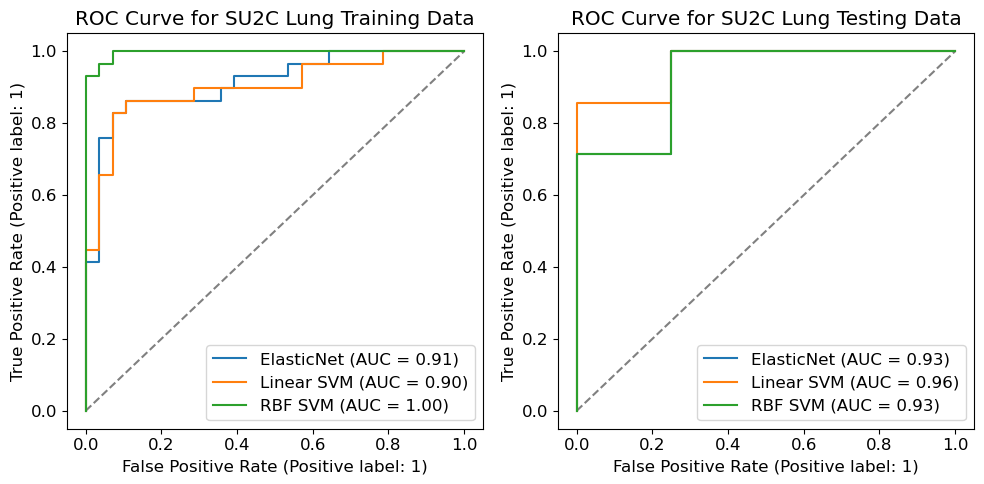

In [15]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")
axes[1].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

for name, model in [("ElasticNet", elastic_net_model), ("Linear SVM", linear_svm_model), ("RBF SVM", rbf_svm_model)]:

    RocCurveDisplay.from_estimator(model, 
                                   trainX.values, 
                                   trainY, 
                                   name=name,
                                   ax=axes[0])

    RocCurveDisplay.from_estimator(model, 
                                   testX.values, 
                                   testY, 
                                   name=name,
                                   ax=axes[1])

axes[0].set_title("ROC Curve for SU2C Lung Training Data")
axes[1].set_title("ROC Curve for SU2C Lung Testing Data")

plt.tight_layout()

import os
os.makedirs("../../../../figures/su2c", exist_ok=True)
plt.savefig("../../../../figures/su2c/ratio-signature-ml-prediction-roc-curve-plots.svg", 
            format='svg', 
            bbox_inches='tight')

In [16]:
#
# Survival Analysis 
#

clinical = pd.read_excel("../../../../data/clinical/original/SU2C-MARK_Supplementary_Tables_Combined_v5_Filtered.xlsx",
                        sheet_name=1,
                        header=2)

In [17]:
# First load the original supplementary file from the SU2C publication
tmb = pd.read_csv("../../../../data/exome/original/SU2C-MARK_Harmonized_Exome_TMB_Signatures_v1.txt", 
                  sep='\t', index_col=0)

tmb = tmb.reindex(trainY.index.union(testY.index))
tmb.loc[trainY.index, "Response"] = trainY[1].values
tmb.loc[testY.index, "Response"] = testY[1].values

pdl1_map = clinical.set_index("Harmonized_SU2C_RNA_Tumor_Sample_ID_v2")["PDL1_TPS"].dropna().to_dict()
tmb["PDL1-TPS"] = tmb.index.map(pdl1_map)

tmb = tmb.dropna()

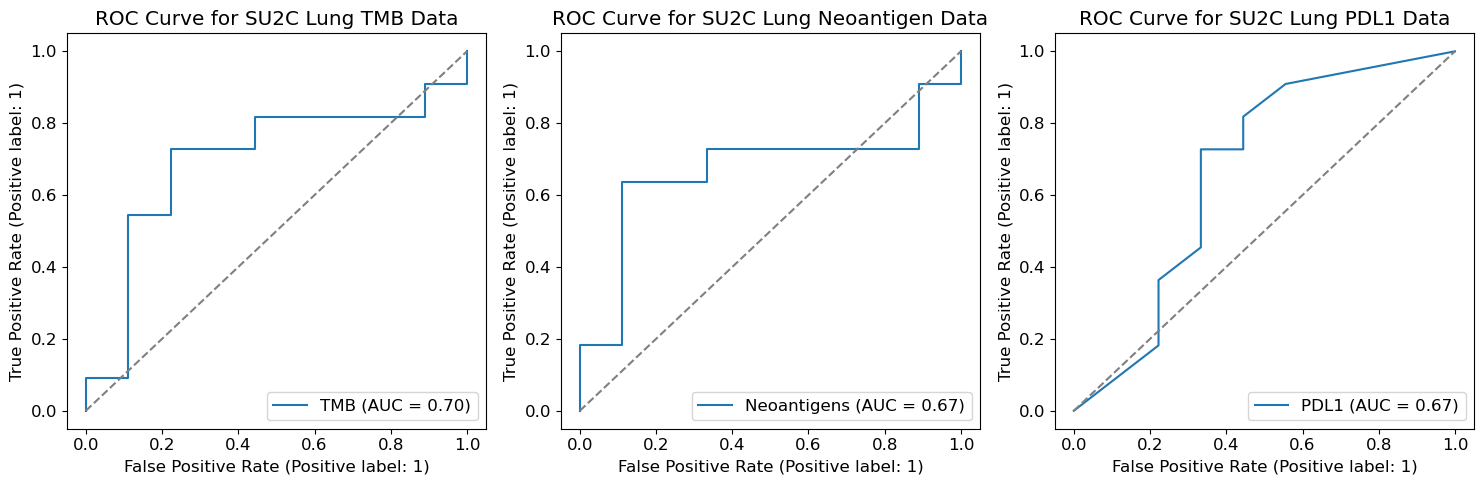

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

#
# TMB
#
axes[0].set_title("ROC Curve for SU2C Lung TMB Data")

RocCurveDisplay.from_predictions(tmb["Response"],
                                 tmb["TMB"],
                                 ax=axes[0],
                                 name="TMB")

axes[0].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

#
# Neoantigen
#
axes[1].set_title("ROC Curve for SU2C Lung Neoantigen Data")

RocCurveDisplay.from_predictions(tmb["Response"],
                                 tmb["Neoantigens"],
                                 ax=axes[1],
                                 name="Neoantigens")

axes[1].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

#
# PDL1
#
axes[2].set_title("ROC Curve for SU2C Lung PDL1 Data")

RocCurveDisplay.from_predictions(tmb["Response"],
                                 tmb["PDL1-TPS"],
                                 ax=axes[2],
                                 name="PDL1")

axes[2].plot(np.linspace(0, 1.0, 10), np.linspace(0.0, 1.0, 10), linestyle='--', color="gray")

plt.tight_layout()
plt.savefig("../../../../figures/su2c/tmb-roc-curve-plot.svg", 
            format='svg', 
            bbox_inches='tight')

In [19]:
len(trainX)

57

In [20]:
clinical.columns

Index(['WES_Cohort_1', 'WES_Cohort_2', 'WES_All', 'RNA_Cohort_1',
       'RNA_Cohort_2', 'RNA_All', 'Institution',
       'Harmonized_SU2C_Participant_ID_v2',
       'Harmonized_SU2C_WES_Tumor_Sample_ID_v2',
       'Harmonized_SU2C_WES_Normal_Sample_ID_v2',
       'Harmonized_SU2C_RNA_Tumor_Sample_ID_v2', 'Pre-treatment_RNA_Sample_QC',
       'Patient_Age_at_Diagnosis', 'Patient_Sex', 'Patient_Race',
       'Patient_Smoking_Status', 'Patient_Smoking_Pack_Years_Harmonized',
       'Histology_Harmonized', 'Histology_Detail', 'Initial_Stage',
       'Initial_Stage_Substage', 'PDL1_TPS', 'PDL1_TPS_Description',
       'Local_Antibody_Clone', 'Clinical_Driver', 'Sequencing_Platform',
       'Advanced_Diagnosis_Date', 'Line_of_Therapy', 'Agent_PD1',
       'Agent_PD1_Category', 'Prior_Platinum', 'Prior_TKI',
       'Harmonized_PFS_Event', 'Harmonized_PFS_Days',
       'Harmonized_Confirmed_BOR', 'Harmonized_BOR_RECIST',
       'Harmonized_OS_Event', 'Harmonized_OS_Days'],
      dtype='object

In [21]:
clinical["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2

SyntaxError: unterminated string literal (detected at line 1) (848208675.py, line 1)

In [ ]:
surv = pd.DataFrame(index=testY.index, columns=["LinearSVMPrediction", "OS-Event", "OS"])

surv["LinearSVMPrediction"] = linear_svm_test_yhat
surv["ElasticNetPrediction"] = elastic_net_test_yhat
surv["RBFSVMPrediction"] = rbf_svm_test_yhat

for sample in surv.index.values:
    print(sample)
    
    surv.loc[sample, "OS-Event"] = clinical.loc[clinical["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2"] == sample, "Harmonized_OS_Event"].item()
    surv.loc[sample, "OS"] = clinical.loc[clinical["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2"] == sample, "Harmonized_OS_Days"].item()
    
    surv.loc[sample, "PFS-Event"] = clinical.loc[clinical["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2"] == sample, "Harmonized_PFS_Event"].item()
    surv.loc[sample, "PFS"] = clinical.loc[clinical["Harmonized_SU2C_RNA_Tumor_Sample_ID_v2"] == sample, "Harmonized_PFS_Days"].item()

In [ ]:
surv.to_csv("../../../../data/clinical/processed/su2c-test-survival.tsv",
            sep='\t')